# Mock Generation Summer 2022
Author: Benjamin Floyd
This version creates pure Poissonian point processes only.

In [1]:
import glob
import json
import re

import astropy.units as u
import corner
import emcee
import matplotlib.pyplot as plt
import numpy as np
from astro_compendium.utils.custom_math import trap_weight
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy.table import Table, vstack, join, unique
from astropy.wcs import WCS
from schwimmbad import MultiPool
from scipy import stats
from scipy.interpolate import interp1d
from scipy.spatial.distance import cdist

%matplotlib inline

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# Set up rng
seed = 3775
rng = np.random.default_rng(seed)
print(f'Using RNG seed: {seed}')

Using RNG seed: 3775


### Mock generation functions

In [2]:
def poisson_point_process(rate, dx, dy=None, lower_dx=0, lower_dy=0):
    """
    Uses a spatial Poisson point process to generate AGN candidate coordinates.

    Parameters
    ----------
    rate : float
        The model rate used in the Poisson distribution to determine the number of points being placed.
    dx, dy : int, Optional
        Upper bound on x- and y-axes respectively. If only `dx` is provided then `dy` = `dx`.
    lower_dx, lower_dy : int, Optional
        Lower bound on x- and y-axes respectively. If not provided, a default of 0 will be used

    Returns
    -------
    coord : np.ndarray
        Numpy array of (x, y) coordinates of AGN candidates
    """

    if dy is None:
        dy = dx

    # Draw from Poisson distribution to determine how many points we will place.
    p = stats.poisson(rate * np.abs(dx - lower_dx) * np.abs(dy - lower_dy)).rvs(random_state=rng)

    # Drop `p` points with uniform x and y coordinates
    x = rng.uniform(lower_dx, dx, size=p)
    y = rng.uniform(lower_dy, dy, size=p)

    # Combine the x and y coordinates.
    coord = np.vstack((x, y))

    return coord

In [3]:
def generate_mock_cluster(cluster_catalog: Table, color_threshold: float, c_true: float) -> Table:
    cluster_z = cluster_catalog['REDSHIFT']
    cluster_m500 = cluster_catalog['M500']
    cluster_r500 = cluster_catalog['R500'] * u.Mpc
    SZ_center = cluster_catalog['SZ_RA', 'SZ_DEC']
    mask_name = cluster_catalog['MASK_NAME']

    # Background Catalog
    # Read in the mask's WCS for the pixel scale and making SkyCoords
    mask_data, mask_hdr = fits.getdata(mask_name, header=True)
    w = WCS(mask_hdr)
    mask_pixel_scale = w.proj_plane_pixel_scales()[0]

    # Also get the mask's image size (- 1 to account for the shift between index and length)
    mask_size_x = w.pixel_shape[0] - 1
    mask_size_y = w.pixel_shape[1] - 1
    mask_radius_pix = (
                max_radius * cluster_r500 * cosmo.arcsec_per_kpc_proper(cluster_z).to(mask_pixel_scale.unit / u.Mpc)
                / mask_pixel_scale).value

    # Find the SZ Center for the cluster we are mimicking
    SZ_center_skycoord = SkyCoord(SZ_center['SZ_RA'], SZ_center['SZ_DEC'], unit='deg')

    # Set the bounding box for the object placement
    SZ_center_pix = SZ_center_skycoord.to_pixel(wcs=w, origin=0, mode='wcs')
    upper_x = SZ_center_pix[0] + mask_radius_pix
    upper_y = SZ_center_pix[1] + mask_radius_pix
    lower_x = SZ_center_pix[0] - mask_radius_pix
    lower_y = SZ_center_pix[1] - mask_radius_pix

    # As we aren't using real masks yet, we will crop our data to fit within the image bounds using the image center as reference
    image_center = SkyCoord.from_pixel(mask_size_x / 2, mask_size_y / 2, wcs=w, origin=0, mode='wcs')

    # Scale the true background rate from arcmin^-2 units to pixel units
    background_rate = c_true / u.arcmin ** 2 * mask_pixel_scale.to(u.arcmin) ** 2
    bkg_coords_pix = poisson_point_process(background_rate, dx=upper_x, dy=upper_y, lower_dx=lower_x, lower_dy=lower_y)
    bkg_cat_df = sdwfs_agn.to_pandas().sample(n=bkg_coords_pix.shape[-1], replace=True, random_state=rng)
    bkg_cat = Table.from_pandas(bkg_cat_df)
    bkg_cat['x'] = bkg_coords_pix[0]
    bkg_cat['y'] = bkg_coords_pix[1]

    bkg_cat = bkg_cat['x', 'y', 'REDSHIFT', 'COMPLETENESS_CORRECTION', f'SELECTION_MEMBERSHIP_{color_threshold:.2f}']
    bkg_cat.rename_columns(['REDSHIFT', f'SELECTION_MEMBERSHIP_{color_threshold:.2f}'],
                           ['galaxy_redshift', 'SELECTION_MEMBERSHIP'])

    # Add flag to background objects
    bkg_cat['CLUSTER_AGN'] = np.full_like(bkg_cat['x'], False)

    # Cluster Catalog
    # Set an array of radii to generate model rates upon
    r_grid = np.linspace(0., max_radius, num=100)

    # Find the maximum rate of our model to use to for homogeneous Poisson process (Using c = 0.0 for a cluster-only model)
    max_rate = np.max(
        model_rate(params=(theta_true, eta_true, zeta_true, beta_true, rc_true, 0.0), z=cluster_z, m=cluster_m500,
                   r500=cluster_r500, radial_dist=r_grid, cluster_id=-1))

    # Convert the max rate from [R_500^-2] units to [pix^-2] units
    max_rate_inv_pix2 = (
                (max_rate / cluster_r500 ** 2) * cosmo.kpc_proper_per_arcmin(cluster_z).to(u.Mpc / u.arcmin) ** 2
                * mask_pixel_scale.to(u.arcmin) ** 2)

    # For the cluster, we need to select only objects within a redshift range of the cluster redshift.
    sdwfs_agn_at_z = sdwfs_agn[np.abs(sdwfs_agn['REDSHIFT'] - cluster_catalog['REDSHIFT']) <= 0.1]

    # Generate the homogenous Poisson process (Again, this will need to be done on pixel units in the future.)
    cl_coords = poisson_point_process(max_rate_inv_pix2, dx=upper_x, dy=upper_y, lower_dx=lower_x, lower_dy=lower_y)
    cl_cat_df = sdwfs_agn_at_z.to_pandas().sample(n=cl_coords.shape[-1], replace=True, random_state=rng)
    cl_cat = Table.from_pandas(cl_cat_df)
    cl_cat['x'] = cl_coords[0]
    cl_cat['y'] = cl_coords[1]

    cl_cat = cl_cat['x', 'y', 'REDSHIFT', 'COMPLETENESS_CORRECTION', f'SELECTION_MEMBERSHIP_{color_threshold:.2f}']
    cl_cat.rename_columns(['REDSHIFT', f'SELECTION_MEMBERSHIP_{color_threshold:.2f}'],
                          ['galaxy_redshift', 'SELECTION_MEMBERSHIP'])

    # Find the separations in r500 units
    cluster_agn_skycoord = SkyCoord.from_pixel(cl_cat['x'], cl_cat['y'], wcs=w, origin=0, mode='wcs')
    radii_arcmin = SZ_center_skycoord.separation(cluster_agn_skycoord).to(u.arcmin)
    radii_r500 = radii_arcmin * cosmo.kpc_proper_per_arcmin(cluster_z).to(u.Mpc / u.arcmin) / cluster_r500

    # Compute model rates at each candidate position
    rate_at_radius = model_rate(params=(theta_true, eta_true, zeta_true, beta_true, rc_true, 0.), z=cluster_z,
                                m=cluster_m500, r500=cluster_r500, radial_dist=radii_r500.value, cluster_id=-1)

    # Perform rejection sampling
    prob_reject = rate_at_radius / max_rate
    alpha = rng.uniform(0., 1., size=len(rate_at_radius))
    cl_cat = cl_cat[prob_reject >= alpha]

    # Add flag to cluster objects
    cl_cat['CLUSTER_AGN'] = np.full_like(cl_cat['x'], True)

    # Merge the catalogs
    los_cat = vstack([cl_cat, bkg_cat])

    # Add cluster information
    los_cat['SPT_ID'] = cluster_catalog['SPT_ID']
    los_cat['SZ_RA'] = SZ_center_skycoord.ra
    los_cat['SZ_DEC'] = SZ_center_skycoord.dec
    los_cat['REDSHIFT'] = cluster_z
    los_cat['M500'] = cluster_m500
    los_cat['R500'] = cluster_r500
    los_cat['MASK_NAME'] = mask_name

    # Convert the coordinates to RA/Dec
    los_coords_skycoord = SkyCoord.from_pixel(los_cat['x'], los_cat['y'], wcs=w, origin=0, mode='wcs')
    los_cat['RA'] = los_coords_skycoord.ra
    los_cat['DEC'] = los_coords_skycoord.dec

    # Record the separations of all the objects in angular units and r500 units
    los_cat['RADIAL_SEP_ARCMIN'] = SZ_center_skycoord.separation(los_coords_skycoord).to(u.arcmin)
    los_cat['RADIAL_SEP_R500'] = los_cat['RADIAL_SEP_ARCMIN'] * cosmo.kpc_proper_per_arcmin(cluster_z).to(
        u.Mpc / u.arcmin) / cluster_r500

    # Filter all objects that are off-images
    los_cat = los_cat[np.all([0 <= los_cat['x'], los_cat['x'] <= mask_size_x, 0 <= los_cat['y'], los_cat['y'] <= mask_size_y], axis=0)]

    # Filter the catalog through the mask
    mask_data = mask_data.astype(bool)
    los_cat = los_cat[mask_data[np.floor(los_cat['y']).astype(int), np.floor(los_cat['x']).astype(int)]]

    # Crop the data to be within 2.5 arcmin of the image center
    # los_coords_skycoord = SkyCoord.from_pixel(los_cat['x'], los_cat['y'], wcs=w, origin=0, mode='wcs')
    # image_center_sep = image_center.separation(los_coords_skycoord).to(u.arcmin)
    # los_cat = los_cat[image_center_sep <= 2.5 * u.arcmin]

    return los_cat

### Good Pixel Fraction Functions

In [4]:
def rebin(a, rebin_factor, wcs=None):
    """
    Rebin an image to the new shape and adjust the WCS.

    Parameters
    ----------
    a: array-like
        Original image.
    rebin_factor: float
        Rebinning scale factor.
    wcs: WCS, optional
        Original image world coordinate system (WCS) object.

    Returns
    -------
    new_image: np.ndarray
        The rebinned image.
    new_wcs: WCS
        The updated WCS for the rebinned object.
    """

    newshape = tuple(rebin_factor * x for x in a.shape)

    assert len(a.shape) == len(newshape)

    slices = [slice(0, old, float(old) / new) for old, new in zip(a.shape, newshape)]
    coordinates = np.mgrid[slices]
    indices = coordinates.astype('i')  # recast the coordinates to int32
    new_image = a[tuple(indices)]

    if wcs is not None:
        new_wcs = wcs.deepcopy()
        new_wcs.pixel_shape = new_image.shape  # Update the NAXIS1/2 values
        new_wcs.wcs.cd /= rebin_factor  # Update the pixel scale

        # Check if the WCS has a PC matrix which is what AstroPy generates. If it exists, just delete it and stick with
        # the CD matrix as the majority of the images have that natively.
        if new_wcs.wcs.has_pc():
            del new_wcs.wcs.pc

        # Transform the reference pixel coordinate
        old_crpix = wcs.wcs.crpix
        new_crpix = np.floor(old_crpix) / a.shape * new_image.shape + old_crpix - np.floor(old_crpix)
        new_wcs.wcs.crpix = new_crpix

        return new_image, new_wcs

    return new_image

In [5]:
def good_pixel_fraction(r, z, r500, center, cluster_id, rescale_factor=None):
    """
    Computes the fraction of unmasked pixels within an annulus.

    Parameters
    ----------
    r: array-like
        Radial axis on which we will form our annuli.
    z: float
        Redshift of the cluster.
    r500: u.Quantity
        R500 radius of the cluster.
    center: Table
        Center of the cluster.
    cluster_id: str
        Cluster name/ID.
    rescale_factor: float, optional
        Factor by which to rescale the original image. This rebins the pixels of the image into pixels of size
        `old_pix / rescale_factor`.

    Returns
    -------
    good_pix_frac: list of float
        A list of the fractional area within each annulus that is unmasked.
    """
    # Read in the mask file and the mask file's WCS
    image, header = mask_dict[cluster_id]  # This is provided by the global variable mask_dict
    image_wcs = WCS(header)

    if rescale_factor is not None:
        image, image_wcs = rebin(image, rescale_factor, wcs=image_wcs)

    # From the WCS get the pixel scale
    pix_scale = image_wcs.proj_plane_pixel_scales()[0]

    # Convert our center into pixel units
    center_pix = image_wcs.wcs_world2pix(center['SZ_RA'], center['SZ_DEC'], 0)

    # Convert our radius to pixels
    r_pix = r * r500 * cosmo.arcsec_per_kpc_proper(z).to(pix_scale.unit / u.Mpc) / pix_scale
    r_pix = r_pix.value

    # Because we potentially integrate to larger radii than can be fit on the image we will need to increase the size of
    # our mask. To do this, we will pad the mask with a zeros out to the radius we need.
    # Find the width needed to pad the image to include the largest radius inside the image.
    width = ((int(round(np.max(r_pix) - center_pix[1])),
              int(round(np.max(r_pix) - (image.shape[0] - center_pix[1])))),
             (int(round(np.max(r_pix) - center_pix[0])),
              int(round(np.max(r_pix) - (image.shape[1] - center_pix[0])))))

    # Ensure that we are adding a non-negative padding width.
    width = tuple(tuple([i if i >= 0 else 0 for i in axis]) for axis in width)

    large_image = np.pad(image, pad_width=width, mode='constant', constant_values=0)

    # Generate a list of all pixel coordinates in the padded image
    image_coords = np.dstack(np.mgrid[0:large_image.shape[0], 0:large_image.shape[1]]).reshape(-1, 2)

    # The center pixel's coordinate needs to be transformed into the large image system
    center_coord = np.array(center_pix) + np.array([width[1][0], width[0][0]])
    center_coord = center_coord.reshape((1, 2))

    # Compute the distance matrix. The entries are a_ij = sqrt((x_j - cent_x)^2 + (y_i - cent_y)^2)
    image_dists = cdist(image_coords, np.flip(center_coord)).reshape(large_image.shape)

    # select all pixels that are within the annulus
    good_pix_frac = []
    for j in np.arange(len(r_pix) - 1):
        pix_ring = large_image[np.where((r_pix[j] <= image_dists) & (image_dists < r_pix[j + 1]))]

        # Calculate the fraction
        good_pix_frac.append(np.sum(pix_ring) / len(pix_ring))

    return good_pix_frac

### Generating Model

In [6]:
def model_rate(params, z, m, r500, radial_dist, cluster_id):
    """
    Our generating model.

    Parameters
    ----------
    params : tuple of floats
        Tuple of parameters.
    radial_dist : array-like
        A vector of radii of objects relative to the cluster center
    cluster_id : int or str
        Used to select correct background prior

    Returns
    -------
    model : np.ndarray
        A surface density profile of objects as a function of radius.
    """

    # Unpack the parameters
    if cluster_id == -1:
        theta, eta, zeta, beta, rc, c0 = params
    else:
        # theta, beta, c0 = (0., 0., *params)
        theta, eta, zeta, beta, rc, c0 = params
    # rc = rc_true

    # In mock generation, we need to be able to skip adding the background surface density redshift relation.
    if cluster_id == -1:
        cz = 0.
    else:
        cz = ((c0 + delta_c(z) * num_clusters) / u.arcmin ** 2)\
             * cosmo.arcsec_per_kpc_proper(z).to(u.arcmin / u.Mpc)**2 * r500**2

    # Our amplitude will eventually be more complicated
    a = theta * (1 + z) ** eta * (m / 1e15) ** zeta

    # Our model rate is an amplitude of cluster-specific trends with a radial dependence with a constant background rate.
    model = a * (1 + (radial_dist / rc) ** 2) ** (-1.5 * beta + 0.5) + cz

    return model

### Bayesian model functions

In [7]:
def lnlike(params: tuple[float, ...]):
    # Compute the likelihood value for each cluster
    cluster_like = []
    for cluster in catalog.group_by('SPT_ID').groups:
        cluster_id = cluster['SPT_ID'][0]
        cluster_z = cluster['REDSHIFT'][0]
        cluster_m500 = cluster['M500'][0]
        cluster_r500 = cluster['R500'][0] * u.Mpc
        ri = cluster['RADIAL_SEP_R500'].value

        # Get the gpf for the cluster_z
        gpf = gpf_dict[cluster_id]

        # Get the selection membership of each object
        # mu_agn = cluster['SELECTION_MEMBERSHIP']
        mu_agn = 1.

        # Compute the model rate at locations of the AGN.
        ni = model_rate(params, cluster_z, cluster_m500, cluster_r500, ri, cluster_id)

        # Compute the ideal model rate at continuous locations
        max_r = 2.5 * u.arcmin * cosmo.kpc_proper_per_arcmin(cluster_z).to(u.Mpc / u.arcmin) / cluster_r500
        rall = np.linspace(0., max_r.value, num=10_000)
        nall = model_rate(params, cluster_z, cluster_m500, cluster_r500, rall, cluster_id)

        # We use a Poisson likelihood function
        ln_like_func = np.sum(np.log(ni * ri * mu_agn)) - trap_weight(nall * 2 * np.pi * rall, rall, weight=gpf)
        cluster_like.append(ln_like_func)

    # Compute the total likelihood value
    total_ln_like = np.sum(cluster_like)
    return total_ln_like

In [8]:
def lnprior(params: tuple[float, ...]):
    # Extract the parameters
    # theta, beta, c0 = (0., 0., *params)
    theta, eta, zeta, beta, rc, c0 = params
    # rc = rc_true

    cluster_prior = []
    for cluster in catalog.group_by('SPT_ID').groups:
        # Get the cluster redshift to set the background hyperparameters
        z = cluster['REDSHIFT'][0]
        h_c = agn_prior_surf_den(z) * num_clusters
        h_c_err = agn_prior_surf_den_err(z) * num_clusters

        # Shift background parameter to redshift-dependent value.
        cz = c0 + delta_c(z) * num_clusters

        # Define parameter ranges
        if (0. <= theta <= np.inf and
            -6. <= eta <= 6. and
            -3. <= zeta <= 3. and
            -3. <= beta <= 3. and
            0.05 <= rc <= 0.5 and
            0. <= cz <= np.inf):
            theta_lnprior = 0.
            eta_lnprior = 0.
            zeta_lnprior = 0.
            beta_lnprior = 0.
            rc_lnprior = 0.
            c_lnprior = -0.5 * np.sum((cz - h_c) ** 2 / h_c_err ** 2)
            # c_lnprior = 0.
        else:
            theta_lnprior = -np.inf
            eta_lnprior = -np.inf
            zeta_lnprior = -np.inf
            beta_lnprior = -np.inf
            rc_lnprior = -np.inf
            c_lnprior = -np.inf
        ln_prior_prob = theta_lnprior + eta_lnprior + zeta_lnprior + beta_lnprior + rc_lnprior + c_lnprior
        cluster_prior.append(ln_prior_prob)

    total_lnprior = np.sum(cluster_prior)
    return total_lnprior

In [9]:
def lnprob(params: tuple[float, ...]):
    # Evaluate log-prior and test if we are within bounds
    lp = lnprior(params)

    if not np.isfinite(lp):
        return -np.inf

    return lnlike(params) + lp

## Generate mock catalog

In [10]:
# Select out a number of clusters to use as examples
n_cl = 6

# Read in the SDWFS IRAGN catalog for use later
sdwfs_agn = Table.read('Data_Repository/Project_Data/SPT-IRAGN/Output/SDWFS_cutout_IRAGN.fits')

# Read in the SPT cluster catalog. We will use real data to source our mock cluster properties.
Bocquet = Table.read(f'Data_Repository/Catalogs/SPT/SPT_catalogs/2500d_cluster_sample_Bocquet18.fits')

# For the 20 common clusters between SPT-SZ 2500d and SPTpol 100d surveys we want to update the cluster information from
# the more recent survey. Thus, we will merge the SPT-SZ and SPTpol catalogs together.
Huang = Table.read(f'Data_Repository/Catalogs/SPT/SPT_catalogs/sptpol100d_catalog_huang19.fits')

# First we need to rename several columns in the SPTpol 100d catalog to match the format of the SPT-SZ catalog
Huang.rename_columns(['Dec', 'xi', 'theta_core', 'redshift', 'redshift_unc'],
                     ['DEC', 'XI', 'THETA_CORE', 'REDSHIFT', 'REDSHIFT_UNC'])

# Now, merge the two catalogs
SPTcl = join(Bocquet, Huang, join_type='outer')
SPTcl.sort(keys=['SPT_ID', 'field'])  # Sub-sorting by 'field' puts Huang entries first
SPTcl = unique(SPTcl, keys='SPT_ID', keep='first')  # Keeping Huang entries over Bocquet
SPTcl.sort(keys='SPT_ID')  # Resort by ID.

# Convert masses to [Msun] rather than [Msun/1e14]
SPTcl['M500'] *= 1e14
SPTcl['M500_uerr'] *= 1e14
SPTcl['M500_lerr'] *= 1e14

# Remove any unconfirmed clusters
SPTcl = SPTcl[SPTcl['M500'] > 0.0]

# For our masks, we will co-op the masks for the real clusters.
masks_files = [*glob.glob(f'Data_Repository/Project_Data/SPT-IRAGN/Masks/SPT-SZ_2500d/quarter_masks/*.fits'),
               *glob.glob(f'Data_Repository/Project_Data/SPT-IRAGN/Masks/SPTpol_100d/quarter_masks/*.fits')]

# Make sure all the masks have matches in the catalog
masks_files = [f for f in masks_files if re.search(r'SPT-CLJ\d+-\d+', f).group(0) in SPTcl['SPT_ID']]

# Select a number of masks at random, sorted to match the order in `full_spt_catalog`.
masks_bank = sorted([masks_files[i] for i in rng.choice(n_cl, size=n_cl, replace=False)],
                    key=lambda x: re.search(r'SPT-CLJ\d+-\d+', x).group(0))

# Find the corresponding cluster IDs in the SPT catalog that match the masks we chose
spt_catalog_ids = [re.search(r'SPT-CLJ\d+-\d+', mask_name).group(0) for mask_name in masks_bank]
spt_catalog_mask = [np.where(SPTcl['SPT_ID'] == spt_id)[0][0] for spt_id in spt_catalog_ids]
selected_clusters = SPTcl['SPT_ID', 'RA', 'DEC', 'M500', 'REDSHIFT', 'REDSHIFT_UNC', 'THETA_CORE', 'XI', 'field'][spt_catalog_mask]

# We'll need the r500 radius for each cluster too.
selected_clusters['R500'] = (3 * selected_clusters['M500'] * u.Msun /
                             (4 * np.pi * 500 *
                              cosmo.critical_density(selected_clusters['REDSHIFT']).to(u.Msun / u.Mpc ** 3))) ** (1 / 3)

# Create cluster names
name_bank = [f'SPT_Mock_{i:03d}' for i in range(n_cl)]

# Combine our data into a catalog
SPT_data = selected_clusters.copy()
SPT_data.rename_columns(['SPT_ID', 'RA', 'DEC'], ['orig_SPT_ID', 'SZ_RA', 'SZ_DEC'])
SPT_data['SPT_ID'] = name_bank
SPT_data['MASK_NAME'] = masks_bank

# Read in the mask files for each cluster
sptcl_catalog_grp = SPT_data.group_by('SPT_ID')
mask_dict = {cluster_id: fits.getdata(f'{mask_file}', header=True) for cluster_id, mask_file
             in zip(sptcl_catalog_grp.groups.keys['SPT_ID'],
                    sptcl_catalog_grp['MASK_NAME'][sptcl_catalog_grp.groups.indices[:-1]])}

In [11]:
# Read in the purity and surface density files
with (open('Data_Repository/Project_Data/SPT-IRAGN/SDWFS_background/SDWFS_purity_color.json', 'r') as f,
      open('Data_Repository/Project_Data/SPT-IRAGN/SDWFS_background/SDWFS_background_prior_distributions.json', 'r') as g):
    sdwfs_purity_data = json.load(f)
    sdwfs_prior_data = json.load(g)
z_bins = sdwfs_purity_data['redshift_bins'][:-1]
threshold_bins = sdwfs_prior_data['color_thresholds'][:-1]

In [12]:
# Set up interpolators
agn_purity_color = interp1d(z_bins, sdwfs_purity_data['purity_90_colors'], kind='previous')
agn_surf_den = interp1d(threshold_bins, sdwfs_prior_data['agn_surf_den'], kind='previous')
agn_surf_den_err = interp1d(threshold_bins, sdwfs_prior_data['agn_surf_den_err'], kind='previous')

# For convenience, set up the function compositions
def agn_prior_surf_den(redshift: float) -> float:
    return agn_surf_den(agn_purity_color(redshift))

def agn_prior_surf_den_err(redshift: float) -> float:
    return agn_surf_den_err(agn_purity_color(redshift))

# Set up an interpolation for the AGN surface density relative to the reference surface density at z = 0
delta_c = interp1d(z_bins, agn_prior_surf_den(z_bins) - agn_prior_surf_den(0.), kind='previous')

In [13]:
cluster_redshifts = SPT_data['REDSHIFT']
redshift_uncert = SPT_data['REDSHIFT_UNC']

# For a cluster at z = 0.6, the color threshold will be [3.6] - [4.5] = 0.61
color_thresholds = [agn_purity_color(z) for z in cluster_redshifts]

# Set the maximum radius (in r500 units) that we will generate out to.
max_radius = 5.  # [R_500]

# Set the rescaling factor for rebinning
rescale_fact = 6  # Factor by which we will rescale the mask images to gain higher resoluti

# We'll boost the number of objects in our sample by duplicating this cluster by a factor.
num_clusters = 50

# We will set our input (true) parameters to be an arbitrary value for cluster and using an approximation of the expected background surface density using our color threshold.
theta_true = 5.0
eta_true = 4.0
zeta_true = -1.0
beta_true = 1.0
rc_true = 0.1
c0_true = agn_prior_surf_den(0.)
c_truths = np.array([agn_prior_surf_den(z) for z in cluster_redshifts])
c_err_truths = np.array([agn_prior_surf_den_err(z) for z in cluster_redshifts])

# We will amplify the true parameters by the number of clusters in the sample.
theta_true *= num_clusters
c0_true *= num_clusters
c_truths *= num_clusters
c_err_truths *= num_clusters
print(f'Input parameters: {theta_true = }, {eta_true = }, {zeta_true = } {beta_true = }, {rc_true = }, {c0_true = :.3f}')

Input parameters: theta_true = 250.0, eta_true = 4.0, zeta_true = -1.0 beta_true = 1.0, rc_true = 0.1, c0_true = 7.905


### Run cluster realization pipeline

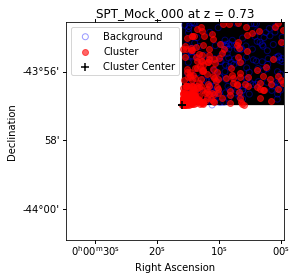

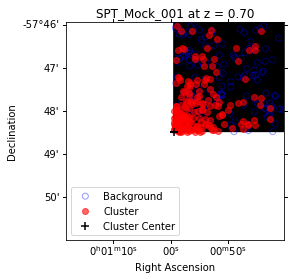

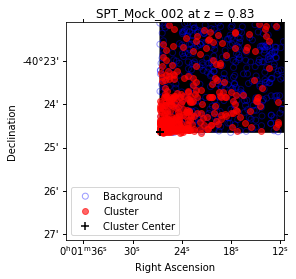

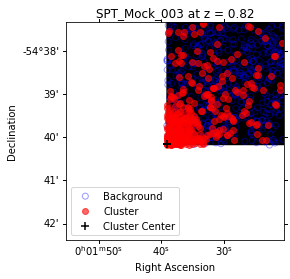

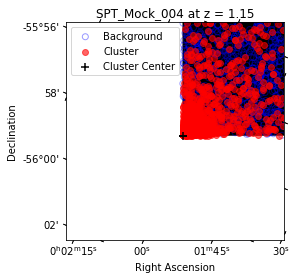

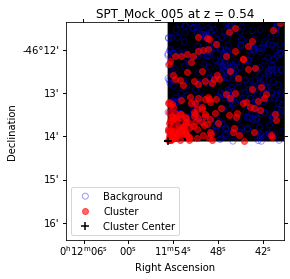

In [14]:
cluster_cats = []
gpf_dict = {}
for cluster_catalog, cluster_color_threshold, bkg_rate_true, bkg_rate_err_true in zip(SPT_data, color_thresholds, c_truths, c_err_truths):
    cat = generate_mock_cluster(cluster_catalog, cluster_color_threshold, bkg_rate_true)
    cluster_cats.append(cat)

    # Compute GPFs
    cluster_id = cat['SPT_ID'][0]
    cluster_z = cat['REDSHIFT'][0]
    cluster_r500 = cat['R500'][0] * u.Mpc
    cluster_sz_cent = cat['SZ_RA', 'SZ_DEC'][0]

    # Determine the maximum integration radius for the cluster in terms of r500 units.
    max_radius_r500 = max_radius

    # Find the appropriate mesh step size. Since we work in r500 units we convert the pixel scale from angle/pix to
    # r500/pix.
    mask_wcs = WCS(mask_dict[cluster_id][1])
    pix_scale = mask_wcs.proj_plane_pixel_scales()[0]
    pix_scale_r500 = pix_scale * cosmo.kpc_proper_per_arcmin(cluster_z).to(u.Mpc / pix_scale.unit) / cluster_r500

    # Generate a radial integration mesh.
    rall = np.arange(0., max_radius_r500, pix_scale_r500 / rescale_fact)

    # Compute the good pixel fractions
    cluster_gpf_all = good_pixel_fraction(rall, cluster_z, cluster_r500, cluster_sz_cent, cluster_id,
                                          rescale_factor=rescale_fact)
    gpf_dict[cluster_id] = cluster_gpf_all

    # Show plot of combined line-of-sight positions
    cluster_objects = cat[cat['CLUSTER_AGN'].astype(bool)]
    background_objects = cat[~cat['CLUSTER_AGN'].astype(bool)]
    mask_img, mask_hdr = fits.getdata(cluster_catalog['MASK_NAME'], header=True)
    wcs = WCS(mask_hdr)
    _, ax = plt.subplots(subplot_kw=dict(projection=wcs))
    ax.imshow(mask_img, origin='lower', cmap='Greys')
    ax.scatter(background_objects['RA'], background_objects['DEC'], edgecolors='blue', facecolors='none', alpha=0.4, label='Background', transform=ax.get_transform('world'))
    ax.scatter(cluster_objects['RA'], cluster_objects['DEC'], edgecolors='red', facecolors='red', alpha=0.6, label='Cluster', transform=ax.get_transform('world'))
    ax.scatter(cluster_catalog['SZ_RA'], cluster_catalog['SZ_DEC'], marker='+', c='k', s=50, label='Cluster Center', transform=ax.get_transform('world'))
    ax.legend()
    ax.set(title=f'{cluster_catalog["SPT_ID"]} at z = {cluster_catalog["REDSHIFT"]:.2f}', xlabel='Right Ascension', ylabel='Declination', aspect=1)
    plt.show()

# Combine all catalogs
master_catalog = vstack(cluster_cats)

In [15]:
cluster_only = master_catalog[master_catalog['CLUSTER_AGN'].astype(bool)]
background_only = master_catalog[~master_catalog['CLUSTER_AGN'].astype(bool)]
len(cluster_only), len(background_only)

(2467, 2011)

In [16]:
catalog = master_catalog

## Apply Bayesian model to refit data

In [17]:
# Set up walkers
ndim = 6
nwalkers = 50
nsteps = 5000

# Initialize walker positions
pos0 = np.array([
    rng.normal(theta_true, 1e-4, size=nwalkers),
    rng.normal(eta_true, 1e-4, size=nwalkers),
    rng.normal(zeta_true, 1e-4, size=nwalkers),
    rng.normal(beta_true, 1e-4, size=nwalkers),
    rng.normal(rc_true, 1e-4, size=nwalkers),
    rng.normal(c0_true, 1e-4, size=nwalkers)]).T

filename='Data_Repository/Project_Data/SPT-IRAGN/MCMC/Mock_Catalog/Chains/Port_Rebuild_Tests/pure_poisson/emcee_mock_pure_poisson.h5'
backend = emcee.backends.HDFBackend(filename=filename, name=f'full_los_{ndim}param_{n_cl}clusters_r500_quarter_masks_gpf')
backend.reset(nwalkers, ndim)
with MultiPool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers=nwalkers, ndim=ndim, log_prob_fn=lnprob, pool=pool, backend=backend)
    sampler.run_mcmc(pos0, nsteps=nsteps, progress=True)

try:
    print(f'Mean autocorrelation time: {(mean_tau := np.mean(sampler.get_autocorr_time())):.2f} steps\n', f'Mean acceptance fraction: {np.mean(sampler.acceptance_fraction):.3f}')
except emcee.autocorr.AutocorrError:
    print(f'Mean autocorrelation time: {(mean_tau := np.mean(sampler.get_autocorr_time(quiet=True))):.2f} steps\n', f'Mean acceptance fraction: {np.mean(sampler.acceptance_fraction):.3f}')

emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:

emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:  params:emcee: Exception while calling your likelihood function:

  params:
  params:
  params:  params:emcee: Exception while calling your likelihood fu

Traceback (most recent call last):


  kwargs:
{}





Traceback (most recent call last):


  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 83, in trap_weight
    integral = np.sum(sub_integral * weight, axis)


Traceback (most recent call last):


{}
   exception:
  kwargs:


  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 83, in trap_weight
    integral = np.sum(sub_integral * weight, axis)



  exception:

  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 1121, in __mul__
    return super().__mul__(other)


  kwargs:  exception:  exception:

  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 83, in trap_weight
    integral = np.sum(sub_integral * weight, axis)


{}


   exception:  exception:

Traceback (most recent call last):
Traceback (most recent call last):


  exception:

  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 1121, in __mul__
    return super().__mul__(other)
Traceback (most recent call last):
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 611, in __array_ufunc__
    result = super().__array_ufunc__(function, method, *arrays, **kwargs)


  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 1121, in __mul__
    return super().__mul__(other)
Traceback (most recent call last):



  exception:
{}  kwargs:


  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 83, in trap_weight
    integral = np.sum(sub_integral * weight, axis)
  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 83, in trap_weight
    integral = np.sum(sub_integral * weight, axis)
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 611, in __array_ufunc__
    result = super().__array_ufunc__(function, method, *arrays, **kwargs)


ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 


  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 83, in trap_weight
    integral = np.sum(sub_integral * weight, axis)
  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 83, in trap_weight
    integral = np.sum(sub_integral * weight, axis)


  exception:

Traceback (most recent call last):


  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 611, in __array_ufunc__
    result = super().__array_ufunc__(function, method, *arrays, **kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 1121, in __mul__
    return super().__mul__(other)
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 1121, in __mul__
    return super().__mul__(other)
ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 
Traceback (most recent call last):


{}


During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 1121, in __mul__
    return super().__mul__(other)
Traceback (most recent call last):


  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 1121, in __mul__
    return super().__mul__(other)
  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 83, in trap_weight
    integral = np.sum(sub_integral * weight, axis)


{}

ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 
Traceback (most recent call last):
  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 83, in trap_weight
    integral = np.sum(sub_integral * weight, axis)
  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 83, in trap_weight
    integral = np.sum(sub_integral * weight, axis)
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 611, in __array_ufunc__
    result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 611, in __array_ufunc__
    result = super().__array_ufunc__(function, method, *arrays, **kwargs)

During handling of the above exception, another exception occurred:

  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compend

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 83, in trap_weight
    integral = np.sum(sub_integral * weight, axis)
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 611, in __array_ufunc__
    result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 611, in __array_ufunc__
    result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 83, in trap_weight
    integral = np.sum(sub_integral * weight, axis)
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 1121, in __mul__
    return super().__mul__(other)



During handling of the above exception, another exception occurred:

  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 1121, in __mul__
    return super().__mul__(other)
  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 83, in trap_weight
    integral = np.sum(sub_integral * weight, axis)
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 1121, in __mul__
    return super().__mul__(other)
ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 
Traceback (most recent call last):
ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 
Traceback (most recent call last):



  exception:

  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
Traceback (most recent call last):
  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 83, in trap_weight
    integral = np.sum(sub_integral * weight, axis)
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 1121, in __mul__
    return super().__mul__(other)
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 1121, in __mul__
    return super().__mul__(other)
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 1121, in __mul__
    return super().__mul__(other)
ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quanti

  exception:

Traceback (most recent call last):
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 611, in __array_ufunc__
    result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 1121, in __mul__
    return super().__mul__(other)
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 611, in __array_ufunc__
    result = super().__array_ufunc__(function, method, *arrays, **kwargs)

During handling of the above exception, another exception occurred:

  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 83, in trap_weight
    integral = np.sum(sub_integral * weight, axis)

During handling of the above exception, another exception occurred:

  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", li

  exception:

  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)


  File "/tmp/ipykernel_436/1752279991.py", line 8, in lnprob
    return lnlike(params) + lp
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 611, in __array_ufunc__
    result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 1121, in __mul__
    return super().__mul__(other)
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 611, in __array_ufunc__
    result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 611, in __array_ufunc__
    result = super().__array_ufunc__(function, method, *arrays, **kwargs)
ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 

During handling of the above exception, another exception occurred:


  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 
ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 611, in __array_ufunc__
    result = super().__array_ufunc__(function, method, *arrays, **kwargs)
Traceback (most recent call last):
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 1121, in __mul__
    return super().__mul__(other)
Traceback (most recent call last):
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 1121, in __mul__
    return super().__mul__(other)


  File "/tmp/ipykernel_436/1752279991.py", line 8, in lnprob
    return lnlike(params) + lp
  File "/tmp/ipykernel_436/1996192625.py", line 27, in lnlike
    ln_like_func = np.sum(np.log(ni * ri * mu_agn)) - trap_weight(nall * 2 * np.pi * rall, rall, weight=gpf)
ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 611, in __array_ufunc__
    result = super().__array_ufunc__(function, method, *arrays, **kwargs)
ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 
ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
Traceback (most recent call last):
  File "/tmp/ipykernel_436/1752279991.py", line 8, in lnprob
    return lnlike(params) + lp

During handling of the above exception, another exception

emcee: Exception while calling your likelihood function:
  params: 

ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 


emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:[ 2.49999831e+02  4.00000900e+00 -1.00013243e+00  9.99925547e-01
  9.99608601e-02  7.90465966e+00]emcee: Exception while calling your likelihood function:


During handling of the above exception, another exception occurred:





emcee: Exception while calling your likelihood function:
  params:
  params:  args:  params: 

  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 92, in trap_weight
    integral = np.add.reduce(sub_integral * weight, axis)


 emcee: Exception while calling your likelihood function:  emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:

ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 


[ 2.50000075e+02  3.99993806e+00 -1.00008893e+00  1.00009609e+00
  9.99859161e-02  7.90469642e+00]  params:[ 2.49999953e+02  4.00019915e+00 -1.00007294e+00  1.00000060e+00
  9.99690915e-02  7.90446000e+00]

[] 
  params:
   args:[ 2.49999964e+02  4.00005613e+00 -9.99886473e-01  1.00007815e+00
  9.99789631e-02  7.90473159e+00]

  File "/tmp/ipykernel_436/1996192625.py", line 27, in lnlike
    ln_like_func = np.sum(np.log(ni * ri * mu_agn)) - trap_weight(nall * 2 * np.pi * rall, rall, weight=gpf)


[ 2.50000005e+02  3.99985230e+00 -1.00010683e+00  9.99836563e-01
  1.00047432e-01  7.90451569e+00]   kwargs:

  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 92, in trap_weight
    integral = np.add.reduce(sub_integral * weight, axis)




[]emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:   args:  args: 

Traceback (most recent call last):




[]


ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 


  params: {}
  params: emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:   kwargs:
[ 2.50000229e+02  3.99991311e+00 -9.99998778e-01  9.99954833e-01
  9.99721794e-02  7.90466714e+00]


   params:  params:

  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)


{}  args:   params:[]
  kwargs:
 


  File "/tmp/ipykernel_436/1752279991.py", line 8, in lnprob
    return lnlike(params) + lp


    params:  exception:[ 2.50000121e+02  4.00005669e+00 -1.00015127e+00  1.00006812e+00
  9.99938967e-02  7.90465153e+00]
[]  exception:

  File "/tmp/ipykernel_436/1996192625.py", line 27, in lnlike
    ln_like_func = np.sum(np.log(ni * ri * mu_agn)) - trap_weight(nall * 2 * np.pi * rall, rall, weight=gpf)


{} 
[ 2.49999993e+02  3.99998818e+00 -9.99947032e-01  9.99826279e-01
  9.99016688e-02  7.90492217e+00]
[ 2.49999896e+02  3.99984145e+00 -1.00015394e+00  9.99927988e-01
  1.00116056e-01  7.90453586e+00]
[ 2.50000088e+02  4.00006326e+00 -9.99918067e-01  1.00027940e+00
  9.99566814e-02  7.90468402e+00]

  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 92, in trap_weight
    integral = np.add.reduce(sub_integral * weight, axis)





  kwargs:  kwargs:


ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 
Traceback (most recent call last):
Traceback (most recent call last):


  args:
  args:  args:  

  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 83, in trap_weight
    integral = np.sum(sub_integral * weight, axis)


  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 83, in trap_weight
    integral = np.sum(sub_integral * weight, axis)


   args:{} emcee: Exception while calling your likelihood function:{}[]

  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 1121, in __mul__
    return super().__mul__(other)
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 1121, in __mul__
    return super().__mul__(other)


[] emcee: Exception while calling your likelihood function:
[]



  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 611, in __array_ufunc__
    result = super().__array_ufunc__(function, method, *arrays, **kwargs)


  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 611, in __array_ufunc__
    result = super().__array_ufunc__(function, method, *arrays, **kwargs)


[ 2.50000121e+02  3.99996277e+00 -9.99984321e-01  9.99840980e-01
  1.00043707e-01  7.90454969e+00]  params:
  kwargs:
  exception:  kwargs:[]
  exception:

ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 


emcee: Exception while calling your likelihood function:  params:  

ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 


  kwargs:


   args: emcee: Exception while calling your likelihood function:


During handling of the above exception, another exception occurred:



  args:emcee: Exception while calling your likelihood function:
   kwargs:

Traceback (most recent call last):

During handling of the above exception, another exception occurred:

Traceback (most recent call last):


{} [ 2.49999949e+02  3.99991729e+00 -1.00005611e+00  1.00000840e+00
  1.00226565e-01  7.90463734e+00]{}[ 2.50000024e+02  3.99996525e+00 -9.99978882e-01  9.99979164e-01
  1.00018169e-01  7.90449542e+00]  params:
 

  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 83, in trap_weight
    integral = np.sum(sub_integral * weight, axis)


[ 2.50000158e+02  3.99996778e+00 -9.99980376e-01  9.99945005e-01
  1.00221718e-01  7.90460916e+00]

  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 83, in trap_weight
    integral = np.sum(sub_integral * weight, axis)



[]

Traceback (most recent call last):





 {}  params:

  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 1121, in __mul__
    return super().__mul__(other)


  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 1121, in __mul__
    return super().__mul__(other)


   args:

emcee: Exception while calling your likelihood function:

  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)


  exception:  args:
 

Traceback (most recent call last):


emcee: Exception while calling your likelihood function:[ 2.49999949e+02  4.00012277e+00 -1.00008152e+00  1.00002609e+00
  1.00050153e-01  7.90474269e+00]  exception:

  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 611, in __array_ufunc__
    result = super().__array_ufunc__(function, method, *arrays, **kwargs)


  exception:  

  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 611, in __array_ufunc__
    result = super().__array_ufunc__(function, method, *arrays, **kwargs)


{}  args:
  kwargs:

  File "/tmp/ipykernel_436/1752279991.py", line 8, in lnprob
    return lnlike(params) + lp



 []  exception:



ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 


  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)


[]

ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 


[ 2.49999999e+02  4.00005897e+00 -1.00007775e+00  1.00013655e+00
  1.00060354e-01  7.90467327e+00]
  params:  

  File "/tmp/ipykernel_436/1996192625.py", line 27, in lnlike
    ln_like_func = np.sum(np.log(ni * ri * mu_agn)) - trap_weight(nall * 2 * np.pi * rall, rall, weight=gpf)


[]
  params:  args:


During handling of the above exception, another exception occurred:

Traceback (most recent call last):
Traceback (most recent call last):


Traceback (most recent call last):
  File "/tmp/ipykernel_436/1752279991.py", line 8, in lnprob
    return lnlike(params) + lp

During handling of the above exception, another exception occurred:





  exception: {}[]

  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 92, in trap_weight
    integral = np.add.reduce(sub_integral * weight, axis)



  kwargs:  

Traceback (most recent call last):
  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 83, in trap_weight
    integral = np.sum(sub_integral * weight, axis)
  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 83, in trap_weight
    integral = np.sum(sub_integral * weight, axis)
  File "/tmp/ipykernel_436/1996192625.py", line 27, in lnlike
    ln_like_func = np.sum(np.log(ni * ri * mu_agn)) - trap_weight(nall * 2 * np.pi * rall, rall, weight=gpf)
Traceback (most recent call last):


  kwargs:

  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 83, in trap_weight
    integral = np.sum(sub_integral * weight, axis)


  args:


Traceback (most recent call last):




[ 2.49999853e+02  3.99996679e+00 -9.99968403e-01  9.99912143e-01
  9.99167555e-02  7.90475419e+00]

ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 


  kwargs: 

  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)


[]

  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 1121, in __mul__
    return super().__mul__(other)


[ 2.50000012e+02  4.00010886e+00 -1.00007233e+00  1.00001860e+00
  1.00212471e-01  7.90459050e+00]

  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 1121, in __mul__
    return super().__mul__(other)
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 92, in trap_weight
    integral = np.add.reduce(sub_integral * weight, axis)
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 1121, in __mul__
    return super().__mul__(other)


  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 83, in trap_weight
    integral = np.sum(sub_integral * weight, axis)
Traceback (most recent call last):


   exception:  kwargs:  params: {}

  File "/tmp/ipykernel_436/1752279991.py", line 8, in lnprob
    return lnlike(params) + lp


  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 611, in __array_ufunc__
    result = super().__array_ufunc__(function, method, *arrays, **kwargs)


  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 611, in __array_ufunc__
    result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  File "/tmp/ipykernel_436/1752279991.py", line 8, in lnprob
    return lnlike(params) + lp
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 611, in __array_ufunc__
    result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 1121, in __mul__
    return super().__mul__(other)


{}

  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 83, in trap_weight
    integral = np.sum(sub_integral * weight, axis)



emcee: Exception while calling your likelihood function: [] 

ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 




{}

  File "/tmp/ipykernel_436/1996192625.py", line 27, in lnlike
    ln_like_func = np.sum(np.log(ni * ri * mu_agn)) - trap_weight(nall * 2 * np.pi * rall, rall, weight=gpf)


  kwargs:

ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 


  args:

  File "/tmp/ipykernel_436/1996192625.py", line 27, in lnlike
    ln_like_func = np.sum(np.log(ni * ri * mu_agn)) - trap_weight(nall * 2 * np.pi * rall, rall, weight=gpf)
ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 


  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 611, in __array_ufunc__
    result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 1121, in __mul__
    return super().__mul__(other)


Traceback (most recent call last):


{}[ 2.49999992e+02  4.00010331e+00 -1.00004899e+00  9.99938816e-01
  9.99544428e-02  7.90463616e+00]  exception:  args:


ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 
  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 92, in trap_weight
    integral = np.add.reduce(sub_integral * weight, axis)

During handling of the above exception, another exception occurred:



  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 92, in trap_weight
    integral = np.add.reduce(sub_integral * weight, axis)

During handling of the above exception, another exception occurred:



  exception:  kwargs:

ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 


  params:




  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 611, in __array_ufunc__
    result = super().__array_ufunc__(function, method, *arrays, **kwargs)


   exception:

  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 83, in trap_weight
    integral = np.sum(sub_integral * weight, axis)

During handling of the above exception, another exception occurred:

ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 
ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 


{}


Traceback (most recent call last):


  args:  exception:

Traceback (most recent call last):


[]
 []

ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 1121, in __mul__
    return super().__mul__(other)
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)



During handling of the above exception, another exception occurred:

  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 83, in trap_weight
    integral = np.sum(sub_integral * weight, axis)
Traceback (most recent call last):
Traceback (most recent call last):


Traceback (most recent call last):


Traceback (most recent call last):

During handling of the above exception, another exception occurred:

  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 611, in __array_ufunc__
    result = super().__array_ufunc__(function, method, *arrays, **kwargs)


[]

  File "/tmp/ipykernel_436/1752279991.py", line 8, in lnprob
    return lnlike(params) + lp


  exception:{}

Traceback (most recent call last):
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 1121, in __mul__
    return super().__mul__(other)
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
Traceback (most recent call last):
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 83, in trap_weight
    integral = np.sum(sub_integral * weight, axis)
Traceback (most recent call last):


  kwargs:

ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 
  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 83, in trap_weight
    integral = np.sum(sub_integral * weight, axis)


  File "/tmp/ipykernel_436/1752279991.py", line 8, in lnprob
    return lnlike(params) + lp
  File "/tmp/ipykernel_436/1996192625.py", line 27, in lnlike
    ln_like_func = np.sum(np.log(ni * ri * mu_agn)) - trap_weight(nall * 2 * np.pi * rall, rall, weight=gpf)
  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 83, in trap_weight
    integral = np.sum(sub_integral * weight, axis)
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 611, in __array_ufunc__
    result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)


  kwargs:


  File "/tmp/ipykernel_436/1752279991.py", line 8, in lnprob
    return lnlike(params) + lp
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)


  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 1121, in __mul__
    return super().__mul__(other)
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 1121, in __mul__
    return super().__mul__(other)
  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 92, in trap_weight
    integral = np.add.reduce(sub_integral * weight, axis)
  File "/tmp/ipykernel_436/1996192625.py", line 27, in lnlike
    ln_like_func = np.sum(np.log(ni * ri * mu_agn)) - trap_weight(nall * 2 * np.pi * rall, rall, weight=gpf)
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 1121, in __mul__
    return super().__mul__(other)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):


  exception:

ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 
  File "/tmp/ipykernel_436/1752279991.py", line 8, in lnprob
    return lnlike(params) + lp


  File "/tmp/ipykernel_436/1996192625.py", line 27, in lnlike
    ln_like_func = np.sum(np.log(ni * ri * mu_agn)) - trap_weight(nall * 2 * np.pi * rall, rall, weight=gpf)
  File "/tmp/ipykernel_436/1752279991.py", line 8, in lnprob
    return lnlike(params) + lp


{}

  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 611, in __array_ufunc__
    result = super().__array_ufunc__(function, method, *arrays, **kwargs)
ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 
  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 92, in trap_weight
    integral = np.add.reduce(sub_integral * weight, axis)
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 611, in __array_ufunc__
    result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 611, in __array_ufunc__
    result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 83, in trap_weight
    integral = np


During handling of the above exception, another exception occurred:

  File "/tmp/ipykernel_436/1996192625.py", line 27, in lnlike
    ln_like_func = np.sum(np.log(ni * ri * mu_agn)) - trap_weight(nall * 2 * np.pi * rall, rall, weight=gpf)


{}  kwargs:

  File "/tmp/ipykernel_436/1996192625.py", line 27, in lnlike
    ln_like_func = np.sum(np.log(ni * ri * mu_agn)) - trap_weight(nall * 2 * np.pi * rall, rall, weight=gpf)
  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 92, in trap_weight
    integral = np.add.reduce(sub_integral * weight, axis)
ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 


Traceback (most recent call last):
ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 
ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 
ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 
Traceback (most recent call last):


  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 92, in trap_weight
    integral = np.add.reduce(sub_integral * weight, axis)
Traceback (most recent call last):


  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 92, in trap_weight
    integral = np.add.reduce(sub_integral * weight, axis)
ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 


emcee: Exception while calling your likelihood function:  exception:


During handling of the above exception, another exception occurred:


During handling of the above exception, another exception occurred:


During handling of the above exception, another exception occurred:

  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)


  exception:

  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 83, in trap_weight
    integral = np.sum(sub_integral * weight, axis)


{}


Traceback (most recent call last):
Traceback (most recent call last):
ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 


emcee: Exception while calling your likelihood function:

Traceback (most recent call last):
  File "/tmp/ipykernel_436/1752279991.py", line 8, in lnprob
    return lnlike(params) + lp
ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 


  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)



  params:


  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/tmp/ipykernel_436/1996192625.py", line 27, in lnlike
    ln_like_func = np.sum(np.log(ni * ri * mu_agn)) - trap_weight(nall * 2 * np.pi * rall, rall, weight=gpf)


  exception: 

  File "/tmp/ipykernel_436/1752279991.py", line 8, in lnprob
    return lnlike(params) + lp


[ 2.49999948e+02  4.00025229e+00 -9.99927048e-01  1.00014655e+00
  1.00134987e-01  7.90470596e+00]

  File "/tmp/ipykernel_436/1752279991.py", line 8, in lnprob
    return lnlike(params) + lp
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 1121, in __mul__
    return super().__mul__(other)
  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 92, in trap_weight
    integral = np.add.reduce(sub_integral * weight, axis)
  File "/tmp/ipykernel_436/1996192625.py", line 27, in lnlike
    ln_like_func = np.sum(np.log(ni * ri * mu_agn)) - trap_weight(nall * 2 * np.pi * rall, rall, weight=gpf)
  File "/tmp/ipykernel_436/1752279991.py", line 8, in lnprob
    return lnlike(params) + lp
  File "/tmp/ipykernel_436/1996192625.py", line 27, in lnlike
    ln_like_func = np.sum(np.log(ni * ri * mu_agn)) - trap_weight(nall * 2 * np.pi * rall, rall, weight=gpf)


[ 2.50000147e+02  3.99989732e+00 -9.99929240e-01  9.99973926e-01
  1.00042778e-01  7.90476664e+00]

Traceback (most recent call last):
  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 92, in trap_weight
    integral = np.add.reduce(sub_integral * weight, axis)
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 611, in __array_ufunc__
    result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 92, in trap_weight
    integral = np.add.reduce(sub_integral * weight, axis)


ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 
  File "/tmp/ipykernel_436/1996192625.py", line 27, in lnlike
    ln_like_func = np.sum(np.log(ni * ri * mu_agn)) - trap_weight(nall * 2 * np.pi * rall, rall, weight=gpf)
  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 83, in trap_weight
    integral = np.sum(sub_integral * weight, axis)
ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 


  args:

  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 92, in trap_weight
    integral = np.add.reduce(sub_integral * weight, axis)
ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 1121, in __mul__
    return super().__mul__(other)



During handling of the above exception, another exception occurred:

ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 


Traceback (most recent call last):
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 611, in __array_ufunc__
    result = super().__array_ufunc__(function, method, *arrays, **kwargs)


[]  args:

  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 


  File "/tmp/ipykernel_436/1752279991.py", line 8, in lnprob
    return lnlike(params) + lp

During handling of the above exception, another exception occurred:



  File "/tmp/ipykernel_436/1996192625.py", line 27, in lnlike
    ln_like_func = np.sum(np.log(ni * ri * mu_agn)) - trap_weight(nall * 2 * np.pi * rall, rall, weight=gpf)


[]

Traceback (most recent call last):
  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 92, in trap_weight
    integral = np.add.reduce(sub_integral * weight, axis)
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)


emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:

ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 1121, in __mul__
    return super().__mul__(other)


  kwargs:



  File "/tmp/ipykernel_436/1752279991.py", line 8, in lnprob
    return lnlike(params) + lp
ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 


  kwargs:
emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function: 

Traceback (most recent call last):
  File "/tmp/ipykernel_436/1752279991.py", line 8, in lnprob
    return lnlike(params) + lp


   params:{}


  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 83, in trap_weight
    integral = np.sum(sub_integral * weight, axis)


  File "/tmp/ipykernel_436/1996192625.py", line 27, in lnlike
    ln_like_func = np.sum(np.log(ni * ri * mu_agn)) - trap_weight(nall * 2 * np.pi * rall, rall, weight=gpf)


  params:

  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 611, in __array_ufunc__
    result = super().__array_ufunc__(function, method, *arrays, **kwargs)


  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 1121, in __mul__
    return super().__mul__(other)


emcee: Exception while calling your likelihood function:

  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 92, in trap_weight
    integral = np.add.reduce(sub_integral * weight, axis)


   exception:[ 2.50000122e+02  3.99999674e+00 -1.00000325e+00  9.99934836e-01
  9.99304472e-02  7.90471934e+00]


ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 
ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 
  File "/tmp/ipykernel_436/1996192625.py", line 27, in lnlike
    ln_like_func = np.sum(np.log(ni * ri * mu_agn)) - trap_weight(nall * 2 * np.pi * rall, rall, weight=gpf)



  params:emcee: Exception while calling your likelihood function:


During handling of the above exception, another exception occurred:



[ 2.49999970e+02  4.00006483e+00 -9.99906092e-01  9.99854299e-01
  9.99904042e-02  7.90476331e+00]
emcee: Exception while calling your likelihood function:


Traceback (most recent call last):



   params:


Traceback (most recent call last):
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)


Traceback (most recent call last):


  params:

  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 83, in trap_weight
    integral = np.sum(sub_integral * weight, axis)


[ 2.50000044e+02  4.00026372e+00 -1.00002895e+00  1.00008657e+00
  1.00032689e-01  7.90463163e+00]

  File "/tmp/ipykernel_436/1752279991.py", line 8, in lnprob
    return lnlike(params) + lp
  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 83, in trap_weight
    integral = np.sum(sub_integral * weight, axis)


[ 2.49999862e+02  3.99995646e+00 -9.99986567e-01  1.00010318e+00
  1.00058423e-01  7.90456449e+00]

  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 1121, in __mul__
    return super().__mul__(other)


 
{}
emcee: Exception while calling your likelihood function:  params:

  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 1121, in __mul__
    return super().__mul__(other)


  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 611, in __array_ufunc__
    result = super().__array_ufunc__(function, method, *arrays, **kwargs)


  args:
  args:

  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 611, in __array_ufunc__
    result = super().__array_ufunc__(function, method, *arrays, **kwargs)


  args:

  File "/tmp/ipykernel_436/1996192625.py", line 27, in lnlike
    ln_like_func = np.sum(np.log(ni * ri * mu_agn)) - trap_weight(nall * 2 * np.pi * rall, rall, weight=gpf)



 [ 2.50000008e+02  3.99985656e+00 -9.99869111e-01  9.99910154e-01
  9.98896811e-02  7.90445359e+00]

  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 611, in __array_ufunc__
    result = super().__array_ufunc__(function, method, *arrays, **kwargs)
ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 


  params:   args:

  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 92, in trap_weight
    integral = np.add.reduce(sub_integral * weight, axis)


    exception:  params:


During handling of the above exception, another exception occurred:

ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 


[ 2.49999931e+02  3.99985825e+00 -9.99883018e-01  1.00008314e+00
  1.00151216e-01  7.90463663e+00][][] 

ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 
ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 




[] 

Traceback (most recent call last):



During handling of the above exception, another exception occurred:

  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 92, in trap_weight
    integral = np.add.reduce(sub_integral * weight, axis)



During handling of the above exception, another exception occurred:



  params:[]


Traceback (most recent call last):


  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)


  args:

Traceback (most recent call last):


[ 2.49999822e+02  4.00001267e+00 -1.00014959e+00  9.99900007e-01
  1.00056071e-01  7.90465089e+00]

ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 


  args:   kwargs:

Traceback (most recent call last):



   kwargs:  kwargs:

  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 83, in trap_weight
    integral = np.sum(sub_integral * weight, axis)
  File "/tmp/ipykernel_436/1752279991.py", line 8, in lnprob
    return lnlike(params) + lp


  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)


  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)


  kwargs:[ 2.49999925e+02  4.00022011e+00 -1.00011025e+00  1.00001287e+00
  9.99702534e-02  7.90462810e+00]

  File "/tmp/ipykernel_436/1996192625.py", line 27, in lnlike
    ln_like_func = np.sum(np.log(ni * ri * mu_agn)) - trap_weight(nall * 2 * np.pi * rall, rall, weight=gpf)


 [ 2.50000026e+02  3.99994526e+00 -9.99979977e-01  9.99960277e-01
  9.98970714e-02  7.90470622e+00][]

  File "/tmp/ipykernel_436/1752279991.py", line 8, in lnprob
    return lnlike(params) + lp


 []

  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 1121, in __mul__
    return super().__mul__(other)


  args:{}

  File "/tmp/ipykernel_436/1752279991.py", line 8, in lnprob
    return lnlike(params) + lp


  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 92, in trap_weight
    integral = np.add.reduce(sub_integral * weight, axis)


{}



  File "/tmp/ipykernel_436/1996192625.py", line 27, in lnlike
    ln_like_func = np.sum(np.log(ni * ri * mu_agn)) - trap_weight(nall * 2 * np.pi * rall, rall, weight=gpf)


{}


  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 611, in __array_ufunc__
    result = super().__array_ufunc__(function, method, *arrays, **kwargs)


  File "/tmp/ipykernel_436/1996192625.py", line 27, in lnlike
    ln_like_func = np.sum(np.log(ni * ri * mu_agn)) - trap_weight(nall * 2 * np.pi * rall, rall, weight=gpf)


{}  args:


ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 


  args:  kwargs:
  kwargs:[]  exception:

  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 92, in trap_weight
    integral = np.add.reduce(sub_integral * weight, axis)
  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 92, in trap_weight
    integral = np.add.reduce(sub_integral * weight, axis)
ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 



    exception:   exception: 



ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 

During handling of the above exception, another exception occurred:

ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 


  exception:[][]
{}  kwargs:
{}

Traceback (most recent call last):
Traceback (most recent call last):


Traceback (most recent call last):


Traceback (most recent call last):
  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 83, in trap_weight
    integral = np.sum(sub_integral * weight, axis)


  kwargs:

  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)


  kwargs:  exception:

  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 83, in trap_weight
    integral = np.sum(sub_integral * weight, axis)


{}  exception:

Traceback (most recent call last):
  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 83, in trap_weight
    integral = np.sum(sub_integral * weight, axis)
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 1121, in __mul__
    return super().__mul__(other)
  File "/tmp/ipykernel_436/1752279991.py", line 8, in lnprob
    return lnlike(params) + lp


  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 1121, in __mul__
    return super().__mul__(other)


  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 1121, in __mul__
    return super().__mul__(other)
  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 83, in trap_weight
    integral = np.sum(sub_integral * weight, axis)
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 611, in __array_ufunc__
    result = super().__array_ufunc__(function, method, *arrays, **kwargs)


{}

Traceback (most recent call last):
  File "/tmp/ipykernel_436/1996192625.py", line 27, in lnlike
    ln_like_func = np.sum(np.log(ni * ri * mu_agn)) - trap_weight(nall * 2 * np.pi * rall, rall, weight=gpf)


{}

  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 611, in __array_ufunc__
    result = super().__array_ufunc__(function, method, *arrays, **kwargs)


  exception:

  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 611, in __array_ufunc__
    result = super().__array_ufunc__(function, method, *arrays, **kwargs)
Traceback (most recent call last):
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 1121, in __mul__
    return super().__mul__(other)


  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 83, in trap_weight
    integral = np.sum(sub_integral * weight, axis)
ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 
  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 92, in trap_weight
    integral = np.add.reduce(sub_integral * weight, axis)


ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 
ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 
  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 83, in trap_weight
    integral = np.sum(sub_integral * weight, axis)



  exception:

  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 611, in __array_ufunc__
    result = super().__array_ufunc__(function, method, *arrays, **kwargs)

During handling of the above exception, another exception occurred:

  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 1121, in __mul__
    return super().__mul__(other)

During handling of the above exception, another exception occurred:


During handling of the above exception, another exception occurred:



  exception:


ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 
Traceback (most recent call last):
ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 1121, in __mul__
    return super().__mul__(other)
Traceback (most recent call last):
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 611, in __array_ufunc__
    result = super().__array_ufunc__(function, method, *arrays, **kwargs)
Traceback (most recent call last):
Traceback (most recent call last):



During handling of the above exception, another exception occurred:

  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 83, in trap_weight
    integral = np.sum(sub_integral * weight, axis)
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 611, in __array_ufunc__
    result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_

ValueError: operands could not be broadcast together with shapes (9999,) (4076,) 

  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/home/ben-work/PycharmProjects/astro-compendium/astro_compendium/utils/custom_math.py", line 83, in trap_weight
    integral = np.sum(sub_integral * weight, axis)
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 1121, in __mul__
    return super().__mul__(other)
  File "/home/ben-work/.conda/envs/astro/lib/python3.10/site-packages/astropy/units/quantity.py", line 611, in __array_ufunc__
    result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  File "/tmp/ipykernel_436/1996192625.py", line 27, in lnlike
    ln_like_func = np.sum(np.log(ni * ri * mu_agn)) - trap_weight(nall * 2 * np.pi * rall, rall, weight=gpf)
  File "/tmp/ipykernel_436/1996192625.py", line 27, in lnlike
    ln_like_func = np.sum(np.log(ni * ri * mu_agn)) - trap_weight(nall * 2 * np.p

In [ ]:
# Plot chains
samples = sampler.get_chain()
labels = [r'$\theta$', r'$\eta$', r'$\zeta$', r'$\beta$', r'$r_c$', r'$C_0$']
truths = [theta_true, eta_true, zeta_true, beta_true, rc_true, c0_true]
# truth, label = truths[-1], labels[-1]
fig, axes = plt.subplots(nrows=ndim, figsize=(10, 7), sharex='col')
if ndim == 1:
    axes.plot(samples[:, :, 0], 'k', alpha=0.3)
    axes.axhline(y=truths[-1], c='b')
    axes.set(ylabel=labels[-1], xlim=[0, len(samples)])
    axes.set(xlabel='Steps')
else:
    for i, (ax, label, truth) in enumerate(zip(axes.flatten(), labels, truths)):
        ax.plot(samples[:, :, i], 'k', alpha=0.3)
        ax.axhline(y=truth, c='b')
        ax.set(ylabel=label, xlim=[0, len(samples)])
    axes[-1].set(xlabel='Steps')
fig.savefig(f'Data_Repository/Project_Data/SPT-IRAGN/MCMC/Mock_Catalog/Plots/Port_Rebuild_Tests/pure_poisson/param_chains_full_los_{ndim}param_{n_cl}clusters_r500_quarter_masks_gpf.pdf')

In [ ]:
# Plot posterior
flat_samples = sampler.get_chain(discard=int(3*mean_tau), flat=True)
if ndim == 1:
    fig = corner.corner(flat_samples, labels=[labels[-1]], truths=[truths[-1]], show_titles=True, quantiles=[0.16, 0.5, 0.84])
else:
    fig = corner.corner(flat_samples, labels=labels, truths=truths, show_titles=True, quantiles=[0.16, 0.5, 0.84])
fig.savefig(f'Data_Repository/Project_Data/SPT-IRAGN/MCMC/Mock_Catalog/Plots/Port_Rebuild_Tests/pure_poisson/corner_full_los_{ndim}param_{n_cl}clusters_r500_quarter_masks_gpf.pdf')

In [ ]:
lnpost = sampler.get_log_prob(flat=True, discard=int(3 * mean_tau))
for i in range(flat_samples.shape[-1]):
    plt.plot(flat_samples[:, i], lnpost, '.')
    plt.show()

In [ ]:
# sampler.__getstate__()

In [ ]:
# import h5py
#
# with h5py.File('Data_Repository/Project_Data/SPT-IRAGN/MCMC/Mock_Catalog/Chains/Port_Rebuild_Tests/pure_poisson/emcee_mock_pure_poisson.h5', 'w') as f:
#     g = f.create_group(name='full_los_308clusters')
#     g.attrs['version'] = emcee.__version__
#     g.attrs['nwalkers'] = nwalkers
#     g.attrs['ndim'] = ndim
#     g.attrs['has_blobs'] = False
#     g.attrs['iteration'] = sampler.iteration
#
#     for i, val in enumerate(sampler._random.get_state()):
#         g.attrs[f'random_state_{i}'] = val
#
#     g.create_dataset(name='accepted', data=np.zeros(shape=ndim))
#     g.create_dataset(name='chain', data=sampler.get_chain())
#     g.create_dataset(name='log_prob', data=sampler.get_log_prob())

In [ ]:
# sampler_readback = emcee.backends.HDFBackend(filename='Data_Repository/Project_Data/SPT-IRAGN/MCMC/Mock_Catalog/Chains/Port_Rebuild_Tests/pure_poisson/emcee_mock_pure_poisson.h5', name='full_los_308clusters')